In [1]:
import random

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

In [2]:
transform = transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

In [3]:
class PairDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x1 = self.data[index]
        x2 = random.choice(self.data)
        return x1, x2, self.label

In [4]:
mnist = MNIST(root='data', train=True, download=True, transform=transform)

# Group by digit 
# trainsets = []
# for digit in range(10):
#     digit_dataset = torch.utils.data.dataset.Subset(mnist, torch.nonzero(mnist.targets == digit).view(-1))
#     trainsets.append(digit_dataset)

In [5]:
# Split and group training data per class
trainsets = []

dataset = MNIST(root='data', train=True, download=True, transform=transform)
for digit in range(10):
    data = torch.utils.data.dataset.Subset(mnist, torch.nonzero(mnist.targets == digit).view(-1)).dataset.data
    trainset = PairDataset(data, digit)
    trainsets.append(trainset)

testset = MNIST(root='./data', train=False, download=True, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


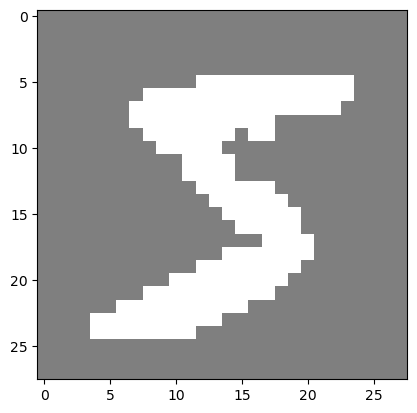

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


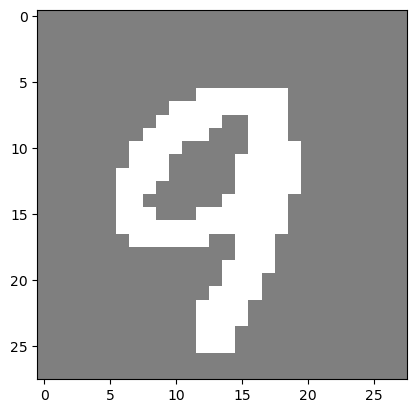

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(DataLoader(trainsets[0]))
data = next(dataiter)
im1, im2, labels = data

# show images
imshow(torchvision.utils.make_grid(im1))
imshow(torchvision.utils.make_grid(im2))

In [7]:
import torch_directml
# select the GPU device if available
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch_directml.is_available():
    device = torch_directml.device(torch_directml.default_device())
else:
    device = torch.device("cpu")

In [8]:
import torch
import torch.nn as nn

In [9]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super(PatchEmbed, self).__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [10]:
class Encoder(nn.Module):
    def __init__(self, img_size, d_model, patch_size, nhead, num_layers):
        super(Encoder, self).__init__()

        
        self.embed = PatchEmbed(img_size*img_size, patch_size, 1, d_model)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model), num_layers=num_layers)
        
        
    def forward(self, x):
        x = self.embed(x)
        x = self.encoder(x)
        return x.flatten(1)

In [11]:
class Model(nn.Module):
    def __init__(self, img_size=28, d_model=32, patch_size=7, nhead=2, num_layers=1, n_classes=10):
        super(Model, self).__init__()

        num_patches = (img_size // patch_size) * (img_size // patch_size)

        self.encoder = Encoder(img_size, d_model, patch_size, nhead, num_layers)
        self.mlp = nn.Linear(d_model * num_patches, n_classes)
    
    def forward(self, x):
        s = self.encoder(x)
        return s, self.mlp(s)

In [12]:
import torch.optim as optim

net = Model(28, 32, 7, 2, 1, 10)
net.to(device)

mse_loss = nn.MSELoss()
# classification_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_params = sum(p.numel() for p in net.parameters())
num_params

13194

In [18]:
batch_size = 100
trainloaders = [DataLoader(ts, batch_size=batch_size, shuffle=True, num_workers=4) for ts in trainsets]

In [19]:
def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

In [20]:
import torch.nn.functional as F

for epoch in range(2):  # loop over the dataset multiple times
    d = 0
    running_loss = 0.0
    for trainloader in trainloaders:
        print(f'training digit {d}')
        d += 1
        for i, data in enumerate(trainloader):
            x1 = data[0].view(batch_size, 1, 28, 28).float().to(device)
            x2 = data[1].view(batch_size, 1, 28, 28).float().to(device)
            label = data[2].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            s1, out1 = net(x1)
            s2, out2 = net(x2)

            # penalize far away embeddings
            repr_loss = F.mse_loss(x1, x2)

            # Maintain variance above a threshold to prevent feature collapse
            var_threshold = 0.5
            std1 = torch.sqrt(s1.var(dim=0) + 0.0001)
            std2 = torch.sqrt(s2.var(dim=0) + 0.0001)
            std_loss = torch.mean(F.relu(1 - std1)) / 2 + torch.mean(F.relu(1 - std2)) / 2
            
            # reduce co-variance such that feature detectors tend to learn unique things
            # cov_loss = torch.mean((s1 - s1.mean(0)) * (s2 - s2.mean(0))) 
            s1 = s1 - s1.mean(dim=0)
            s2 = s2 - s2.mean(dim=0)
            cov_s1 = (s1.T @ s1) / (batch_size - 1)
            cov_s2 = (s2.T @ s2) / (batch_size - 1)
            cov_loss = off_diagonal(cov_s1).pow_(2).sum().div(
                28*28
            ) + off_diagonal(cov_s2).pow_(2).sum().div(28*28)

            
            loss = torch.log(repr_loss + std_loss + cov_loss)
            
            # propagate back the gradients and update the model parameters/weights
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            if i % 1000 == 999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
print('Finished Training')

training digit 0
training digit 1
training digit 2
training digit 3
training digit 4
training digit 5
training digit 6
training digit 7
training digit 8
training digit 9
training digit 0
training digit 1
training digit 2
training digit 3
training digit 4
training digit 5
training digit 6
training digit 7
training digit 8
training digit 9
Finished Training


In [21]:
PATH = './mnist_transformer_patched.pth'
torch.save(net.state_dict(), PATH)

In [22]:
classes = (
    'Zero',   
    'One',    
    'Two',   
    'Three',  
    'Four',    
    'Five', 
    'Six',  
    'Seven',  
    'Eight',   
    'Nine'  )

In [23]:
batch_size = 5
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


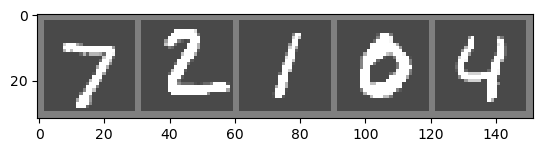

GroundTruth:  Seven Two   One   Zero  Four 


In [24]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j].item()]:5s}' for j in range(batch_size)))

In [25]:
net = Model()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [26]:
_, outputs = net(images)

In [32]:
outputs.shape

torch.Size([5, 10])

In [28]:
_, predicted = torch.max(outputs, 1)
print(predicted)

# print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
#                               for j in range(4)))

tensor([5, 7, 5, 7, 5])


In [29]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        _, outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 8 %


In [30]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        _, outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Zero  is 11.0 %
Accuracy for class: One   is 5.3 %
Accuracy for class: Two   is 2.6 %
Accuracy for class: Three is 0.4 %
Accuracy for class: Four  is 0.2 %
Accuracy for class: Five  is 50.7 %
Accuracy for class: Six   is 0.1 %
Accuracy for class: Seven is 17.6 %
Accuracy for class: Eight is 0.0 %
Accuracy for class: Nine  is 4.0 %
